# Modélisation du SP500

On récupère les données via quandmod et on plot la série brut et les rendements journaliers.

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.



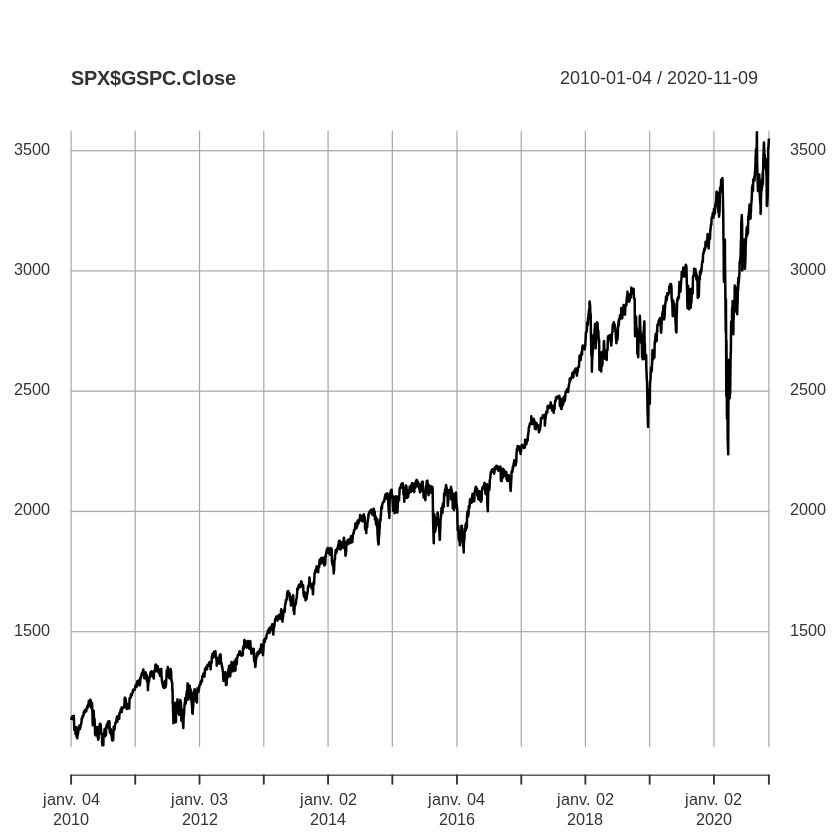

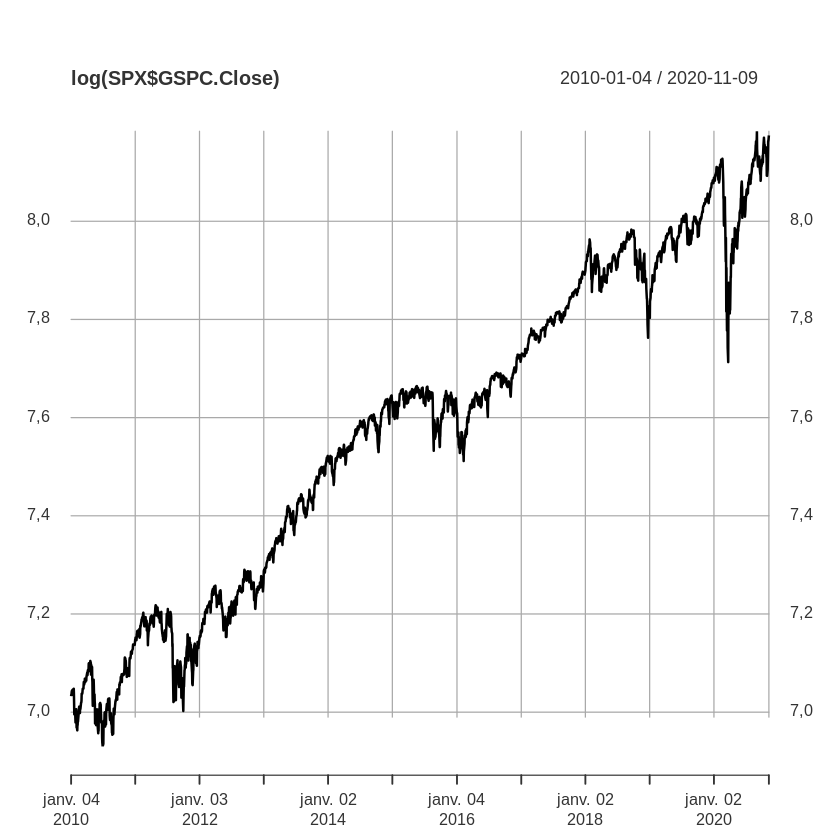

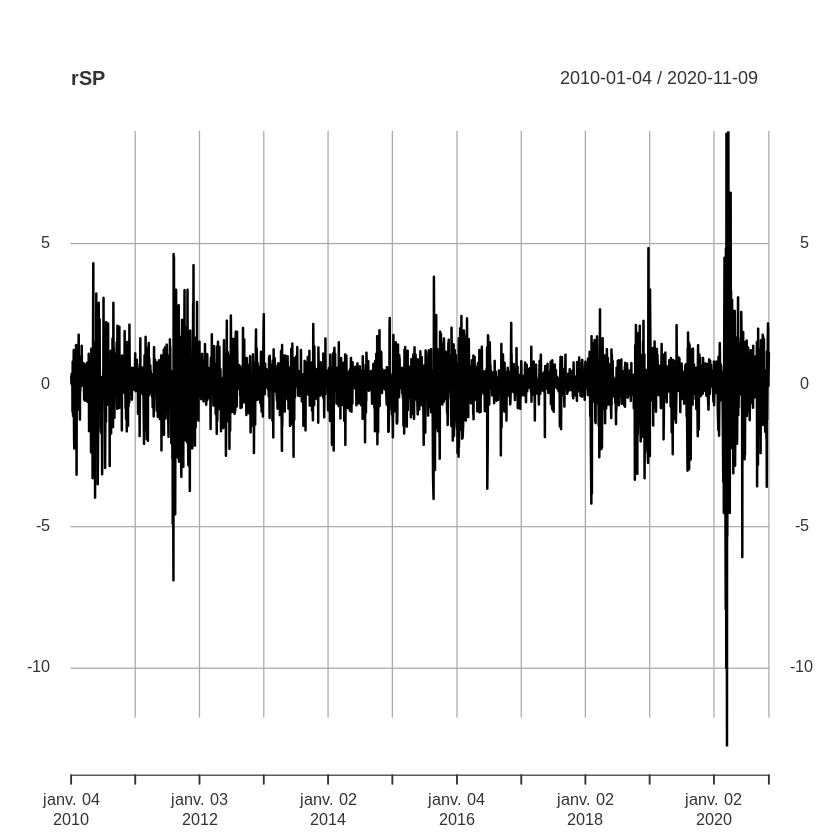

In [1]:
library(quantmod)
SPX <- getSymbols("^GSPC",auto.assign = FALSE, from = "2010-01-01")
plot(SPX$GSPC.Close)
rSP <- 100*(diff(log(SPX$GSPC.Close)))
plot(log(SPX$GSPC.Close))
plot(rSP)


### Modélisation linéaire

On commence par estimer un ARMA(1,1). On effectue aussi le diagnostic du modèle


          Length Class  Mode     
coef         3   -none- numeric  
sigma2       1   -none- numeric  
var.coef     9   -none- numeric  
mask         3   -none- logical  
loglik       1   -none- numeric  
aic          1   -none- numeric  
arma         7   -none- numeric  
residuals 2732   ts     numeric  
call         3   -none- call     
series       1   -none- character
code         1   -none- numeric  
n.cond       1   -none- numeric  
nobs         1   -none- numeric  
model       10   -none- list     

        ar1         ma1   intercept 
-0,47374701  0,32258763  0,04169734 
                    ar1           ma1     intercept
ar1        4,268384e-03 -4,350564e-03 -6,189217e-09
ma1       -4,350564e-03  4,750513e-03  9,388551e-08
intercept -6,189217e-09  9,388551e-08  3,531685e-04
       ar1        ma1  intercept 
-110,98978   67,90585  118,06642 


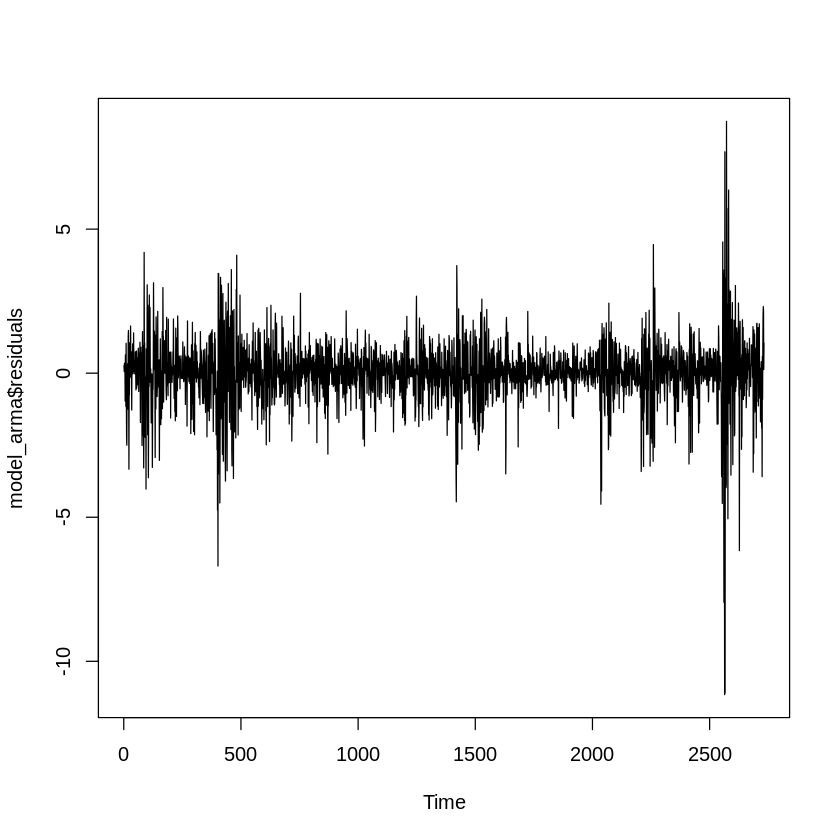

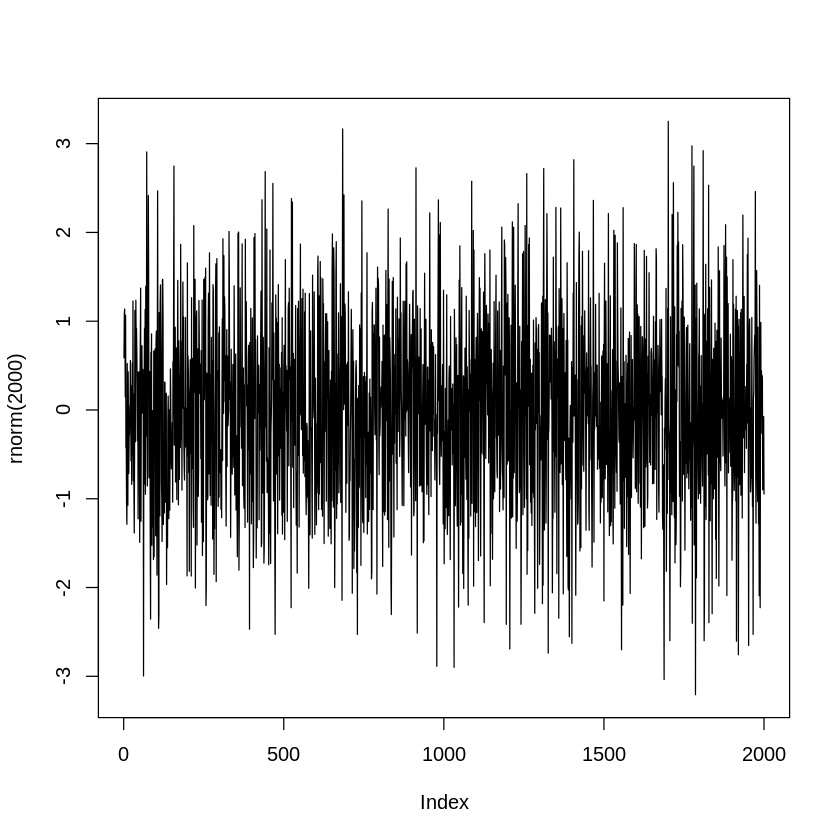

In [2]:
rSP <- na.omit(rSP)
model_arma <- arima(rSP, c(1,0,1))
summary(model_arma)
print(model_arma$coef)
print(model_arma$var.coef)
print(model_arma$coef/diag(model_arma$var.coef))
plot(model_arma$residuals)
plot(rnorm(2000), type='l')

Ces résidus ne ressemblent pas à un bruit blanc. On va effectuer quelqus tests pour s'en rendre compte. 



In [3]:
library(tseries)
jarque.bera.test(na.omit(model_arma$residuals))
Box.test(resid(model_arma),type="Ljung",lag=20,fitdf=1)
Box.test(resid(model_arma)^2,type="Ljung",lag=20,fitdf=1)


	Jarque Bera Test

data:  na.omit(model_arma$residuals)
X-squared = 22851, df = 2, p-value < 2,2e-16



	Box-Ljung test

data:  resid(model_arma)
X-squared = 137,48, df = 19, p-value < 2,2e-16



	Box-Ljung test

data:  resid(model_arma)^2
X-squared = 3281,3, df = 19, p-value < 2,2e-16


On rejette la normalité, on rejtte la non-autocorrélation et on rejette la non-autocorrélation des carrés des résidus...

###  Modélisation non-linéaire en variance PART 1

Estimation d'un GARCH(1,1) sur les résidus fit du moèle ARMA



 ***** ESTIMATION WITH ANALYTICAL GRADIENT ***** 


     I     INITIAL X(I)        D(I)

     1     1,078539e+00     1,000e+00
     2     5,000000e-02     1,000e+00
     3     5,000000e-02     1,000e+00

    IT   NF      F         RELDF    PRELDF    RELDX   STPPAR   D*STEP   NPRELDF
     0    1  1,458e+03
     1    2  1,425e+03  2,25e-02  9,08e-01  4,9e-01  1,3e+03  1,0e+00  6,01e+02
     2    4  1,221e+03  1,43e-01  1,14e-01  2,3e-01  2,0e+00  5,0e-01  5,07e+01
     3    6  1,186e+03  2,86e-02  3,27e-02  5,5e-02  1,3e+02  1,0e-01  2,65e+02
     4    8  1,084e+03  8,58e-02  7,36e-02  2,1e-01  2,1e+00  4,0e-01  1,93e+02
     5   10  1,044e+03  3,67e-02  4,84e-02  4,6e-02  2,2e+00  8,0e-02  5,38e+02
     6   11  1,024e+03  1,97e-02  2,07e-02  5,5e-02  2,0e+00  8,0e-02  1,82e+02
     7   13  1,020e+03  3,30e-03  4,24e-03  9,4e-03  3,8e+00  1,6e-02  1,25e+02
     8   14  1,017e+03  3,25e-03  3,32e-03  8,7e-03  2,9e+00  1,6e-02  3,34e+01
     9   15  1,013e+03  4,34e-03  4,98e-03  2,0e-02 

Warning message in printCoefmat(x$coef, digits = digits, signif.stars = signif.stars, :
“NAs introduits lors de la conversion automatique”


Call:
garch(x = resid(model_arma), order = c(1, 1))

Model:
GARCH(1,1)

Residuals:
     Min       1Q   Median       3Q      Max 
-5,97442 -0,49096  0,05739  0,60171  3,64013 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)    
a0  0,037268    0,003656    10,19   <2e-16 ***
a1  0,188476    0,013596    13,86   <2e-16 ***
b1  0,783061    0,013959    56,10   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘.’ 0,1 ‘ ’ 1

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 744,79, df = 2, p-value < 2,2e-16


	Box-Ljung test

data:  Squared.Residuals
X-squared = 8,1828e-05, df = 1, p-value = 0,9928


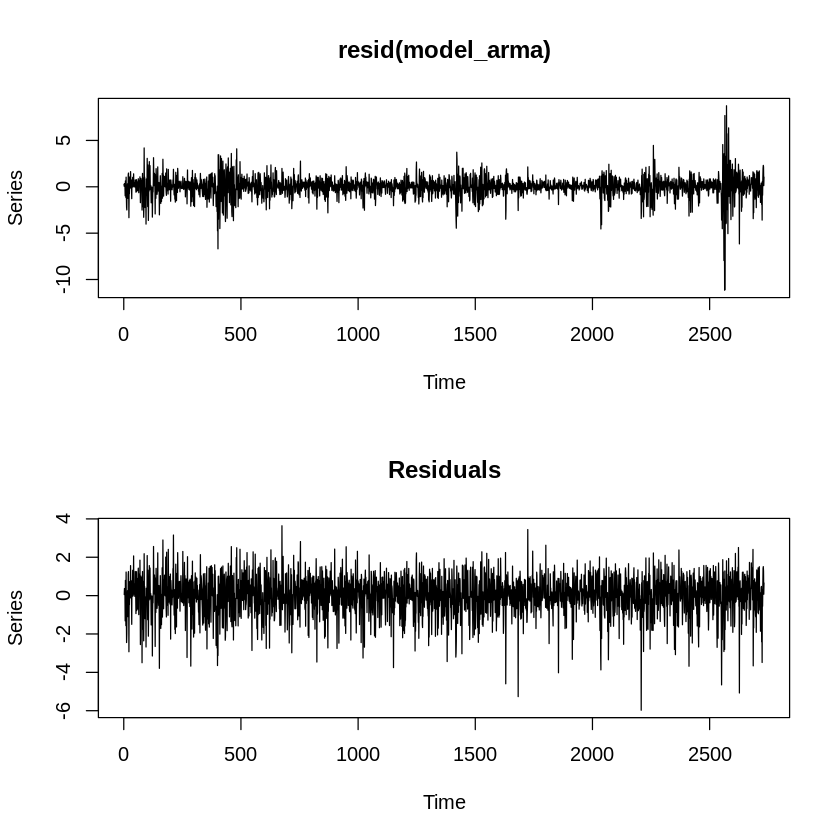

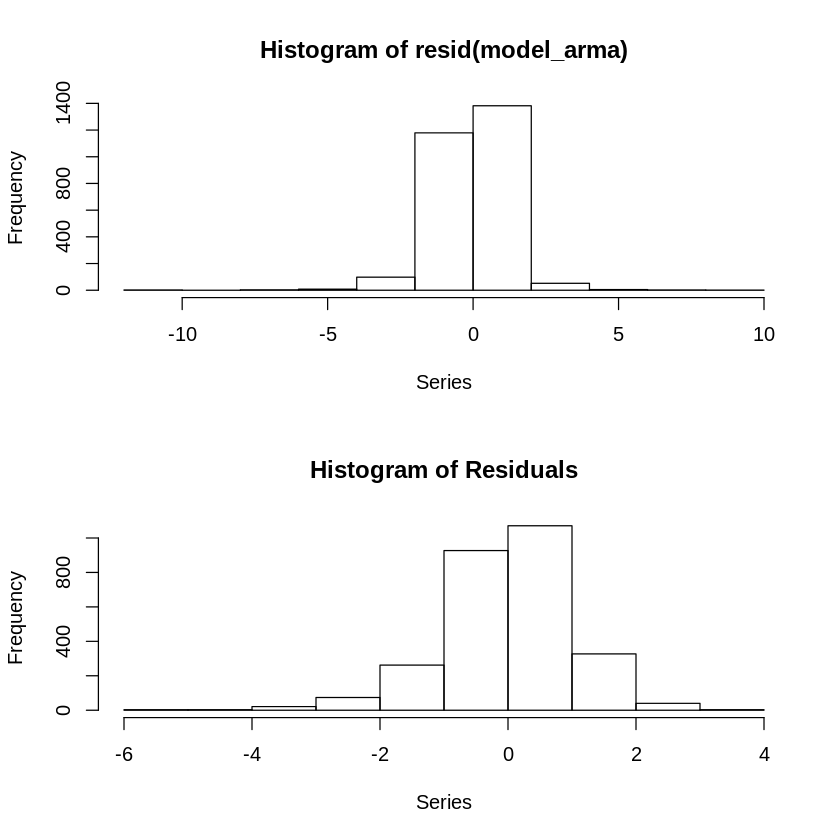

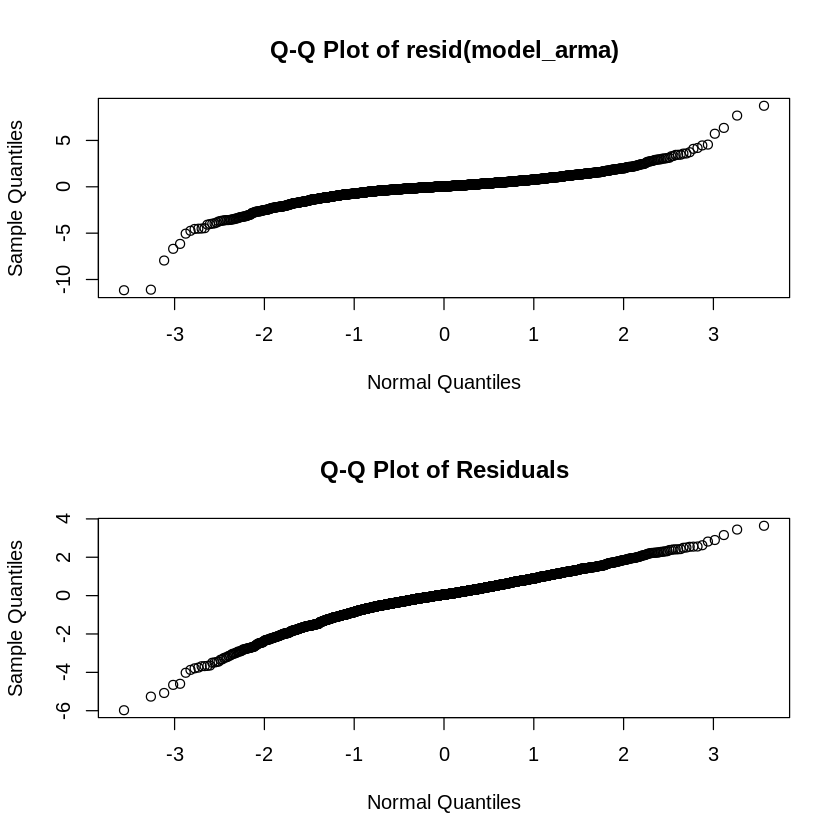

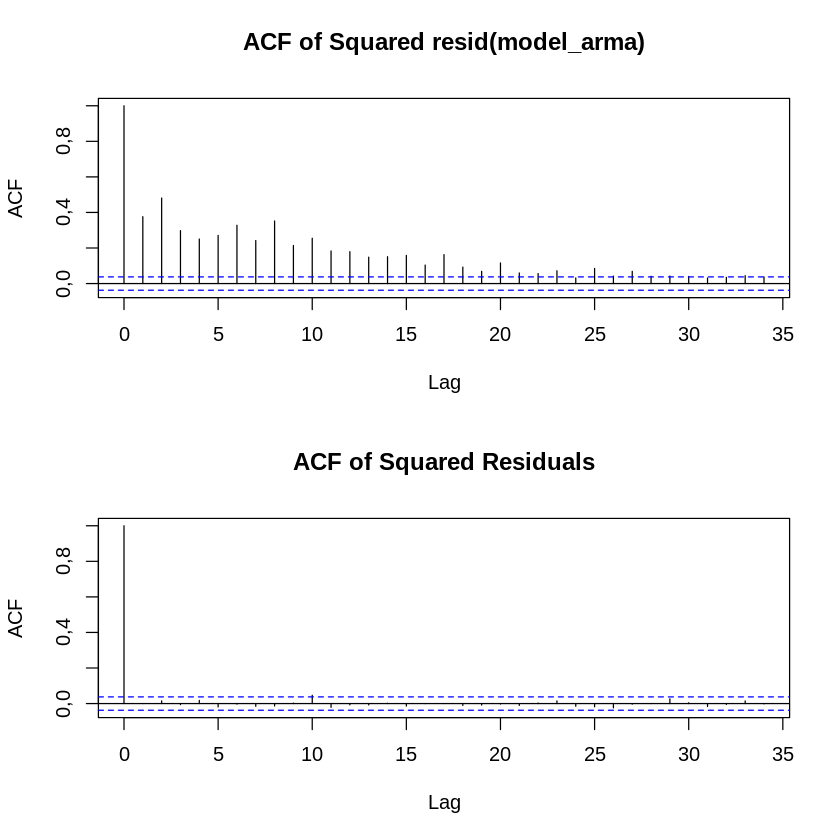

In [4]:
model.garch <- garch(resid(model_arma), order = c(1,1))  
summary(model.garch)                    
plot(model.garch)    

Loading required package: timeDate
Loading required package: timeSeries

Attaching package: ‘timeSeries’

The following object is masked from ‘package:zoo’:

    time<-

Loading required package: fBasics

Attaching package: ‘fBasics’

The following object is masked from ‘package:TTR’:

    volatility




Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(0, 0)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 1)
 ARMA Order:                0 0
 Max ARMA Order:            0
 GARCH Order:               1 1
 Max GARCH Order:           1
 Maximum Order:             1
 Conditional Dist:          norm
 h.start:                   2
 llh.start:                 1
 Length of Series:          2732
 Recursion Init:            mci
 Series Scale:              1,094704

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                      U           V params includes
    mu     -0,000642491 6,42491e-04    0,0    FALSE
    omega   0,000001000 1,00000e+02    0,1     TRUE
    alpha1  0,000000010 1,00000e+00    0,1     TRUE
    gamma1 -0,999999990 1,00000e+00    0,1    FALSE
    beta1   0,000000010 1,00000e+00    0,8     TRUE
    

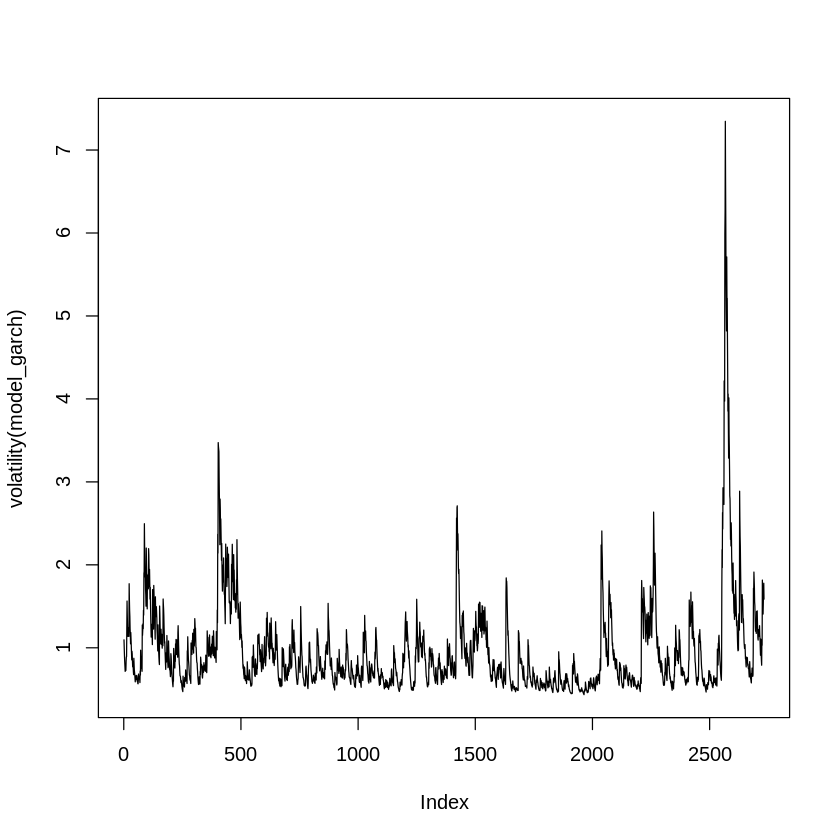

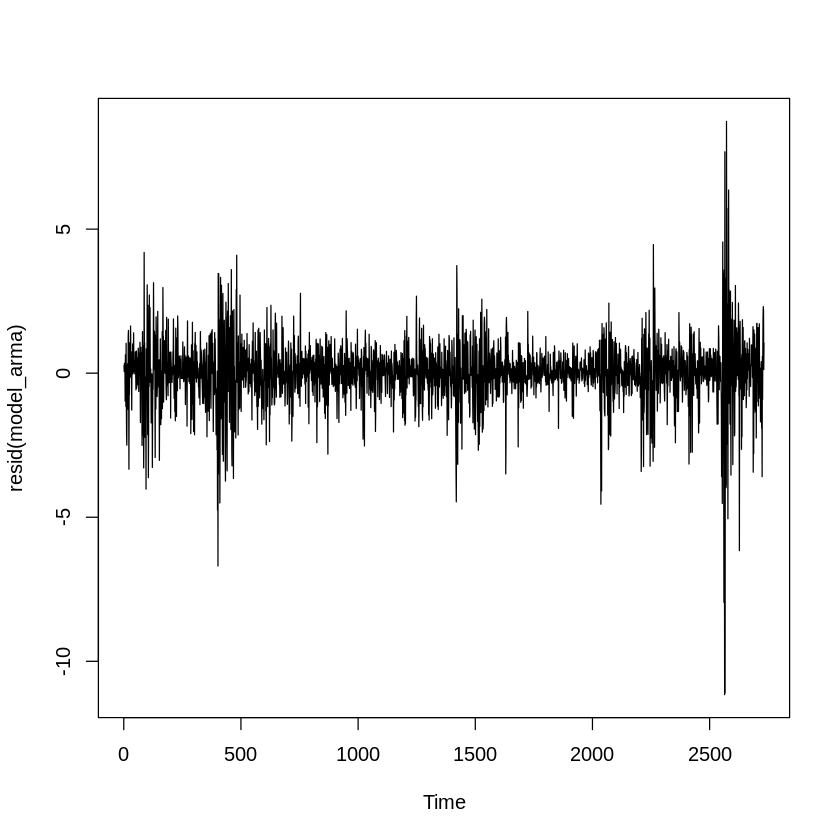

In [7]:
library(fGarch)
model_garch <- garchFit(formula = ~ garch(1, 1), data = resid(model_arma), cond.dist = c("norm"), include.mean = FALSE)
plot(volatility(model_garch),type="l")
plot(resid(model_arma))

## VaR GARCH

$$ VaR(X)=\mu+\sigma\mathcal{N}^{-1}(\alpha) $$

* $\mu$ est la moyenne des rendements journaliers
* $\sigma$ est l'écart-type
* \mathcal{N}^{-1}(X) est la fonction de densité inverse de la loi Gaussienne pour le niveau de confiance $\alpha$



In [9]:
library(ggplot2)
library(rugarch)

gspec11 <- ugarchspec(variance.model = list(model = "sGARCH", 
                      garchOrder = c(1, 1)),
                      mean.model=list(armaOrder=c(1,1)),  
                      distribution="norm")

#Rolling Estimation
T <- length(rSP)-200
roll11 <- ugarchroll(gspec11, rSP, n.start=T,
                     refit.every = 20, refit.window = "moving",
                     VaR.alpha = c(0.025, 0.05))
                      
VaRGARCH <- roll11@forecast$VaR[,2]
